# <span style = 'color: red'>**Práctica dos.** Aprendizaje de máquina. *Redes neuronales*</span>

# ***Parte uno.*** **CNN y LeNET5.**

## **Simón Cuartas Rendón**

En este *notebook* de Python se aborda el desarrollo del **primer problema** de la *práctica dos* del curso de **Aprendizaje de Máquina**.

A continuación, se abren los paquetes que se usarán para dar solución al problema propuesto.

**Anotación.** Este *notebook* está disponible en línea para facilitar su revisión. Se puede acceder al repositorio de GitHub [aquí](https://github.com/scuartasr/aprendmaq_entregable_2/tree/main), y en particular, a este cuaderno [aquí](https://github.com/scuartasr/aprendmaq_entregable_2/blob/main/Cuadernos/01_cnn_lenet5.ipynb).

In [1]:
#
# Apertura de paquetes generales relevantes
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Apertura de paquetes para el trabajo con RNN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, InputLayer

# Otras librerías analíticas
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from keras.losses import SparseCategoricalCrossentropy

# Otras librerías
from keras.utils import plot_model

## <span style = 'color: cyan'>***1.1.***</span> Apertura del marco de datos y revisión inicial

In [2]:
#
# Apertura
direcc = '../Datos/Digit/dataDigit.csv'
digits = pd.read_csv(direcc)

# Dimensión
print(f'El marco de datos tiene {digits.shape[0]} filas y {digits.shape[1]} columnas.')

El marco de datos tiene 42000 filas y 785 columnas.


Nótese que el marco de datos contiene $785$ columnas. Esto obedece a que cada imagen está compuesta por $28 \ \times 28 = 784$ píxeles. El píxel restante corresponde a la etiqueta del dígito que se pretende representar. Además, se tienen un total de $42,000$ observaciones.

En teoría, este marco de datos debería estar compuesto únicamente de columnas de tipo entero. Para verificar esto, se va a crear una lista que coleccione el nombre de todas las columnas que tienen esta tipología de dato. Así, si es correcto, el tamaño de la lista debe ser de exactamente $785$ elementos.

In [3]:
#
# Columnas de tipo entero
int_cols = [col for col in digits.columns if digits[col].dtype == 'int64']
print(f'El marco de datos tiene {len(int_cols)} columnas de tipo entero.')

El marco de datos tiene 785 columnas de tipo entero.


Igualmente, se va a verificar que el marco de datos esté completo:

In [4]:
# Verificación de que el marco de datos esté completo
digits.isna().sum().sum() == 0

np.True_

## <span style = 'color: cyan'>***1.2.***</span> Visualización

Ahora, se graficarán dieciséis instancias aleatorias del marco de datos.

In [5]:
#
# Separación de objetivo y características
X = digits.drop('label', axis=1)
y = digits['label']

In [6]:
#
# Semilla para pseudoaleatorización
np.random.seed(103)
indices = np.random.choice(X.shape[0], size=16, replace=False)
X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

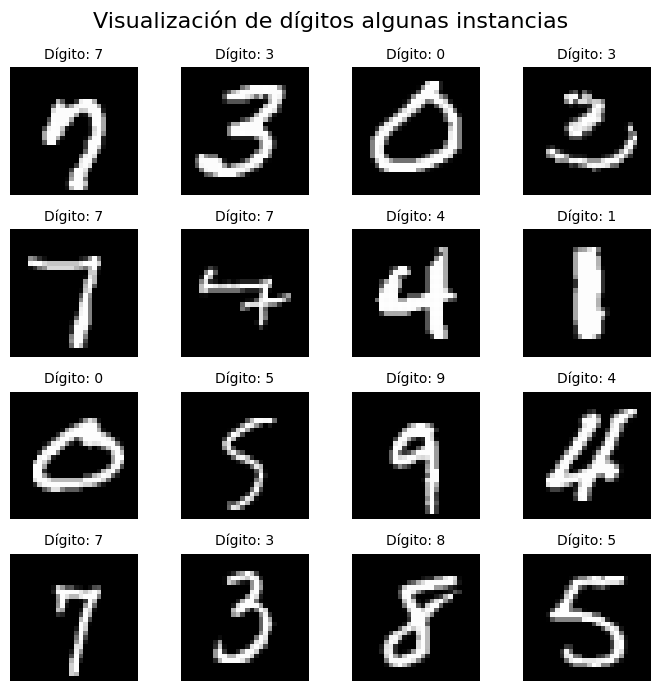

In [7]:
#
# Visualización

fig1, axes1 = plt.subplots(4, 4, figsize=(7, 7), )
axes1 = axes1.flatten()
for digito, eje in enumerate(axes1):
    imagen = X_sample.iloc[digito].values.reshape(28, 28)
    eje.imshow(imagen, cmap='gray')
    eje.set_title(f'Dígito: {y_sample.iloc[digito]}', fontsize=10,)
    eje.axis('off')
plt.suptitle('Visualización de dígitos algunas instancias', fontsize=16, )
plt.tight_layout()
plt.show()

El objetivo, pues, es que a partir de la coloración de cada uno de los píxeles, se pueda predecir a qué dígito está asociada una imagen particular.

## <span style = 'color: cyan'>***1.3.***</span> Estructuración del marco de datos


Ahora bien, teniendo en cuenta que los datos tienen una configuración $28 \times 28$, primero se le agregarán dos pares de columnas de ceros a la izquierda y a la derecha (un par a cada lado) para alcanzar la configuración $32 \times 32$ que requiere un red de tipo LeNET-5.

In [8]:
#
# Estructuración del marco de datos
X_np = X.to_numpy()
X_reest = X_np.reshape(-1, 28, 28)

# Padding
X_pad = np.pad(X_reest, ((0, 0), (2, 2), (2, 2)), mode='constant', )

# Adición del canal
X_pad = np.expand_dims(X_pad, axis=-1)

X_pad.shape

(42000, 32, 32, 1)

## <span style = 'color: cyan'>***1.4.***</span> Normalización

Para facilitar el ajuste del modelo en la red neuronal, se normalizarán las entradas de la matriz de diseño. Para ello, al tratarse de datos asociados a imágenes, basta con dividir las entradas entre $255$.

In [9]:
#
# Normalización
X_scaled = X_pad / 255.0

## <span style = 'color: cyan'>***1.5.***</span> Configuración de la arquitectura

A continuación, se definirá la arquitectura de la red neuronal siguiendo las indicaciones de la guía:

In [10]:
#
# Definición del modelo LeNET-5
modelo = Sequential()

# 0. Entrada
modelo.add(InputLayer(input_shape=(32, 32, 1)))

# 1. Convolucional
modelo.add(Conv2D(filters=6, kernel_size=(5, 5, ), activation='relu', ))

# 2. Average pooling
modelo.add(AveragePooling2D(pool_size=(2, 2, ), ))

# 3. Convolucional
modelo.add(Conv2D(filters=16, kernel_size=(5, 5, ), activation='relu', ))

# 4. Average pooling
modelo.add(AveragePooling2D(pool_size=(2, 2, ), ))

# 4.1. Aplanamiento
modelo.add(Flatten())

# 5. Densa
modelo.add(Dense(units=120, activation='relu', ))

# 6. Densa
modelo.add(Dense(units=84, activation='relu', ))

# 7. Densa de salida
modelo.add(Dense(units=10, activation='softmax', ))

/Users/scuartasr/Documents/Maestría/aprenmaq/entreg2/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [11]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

Visualmente, el modelo de red neuronal definido luce como sigue:

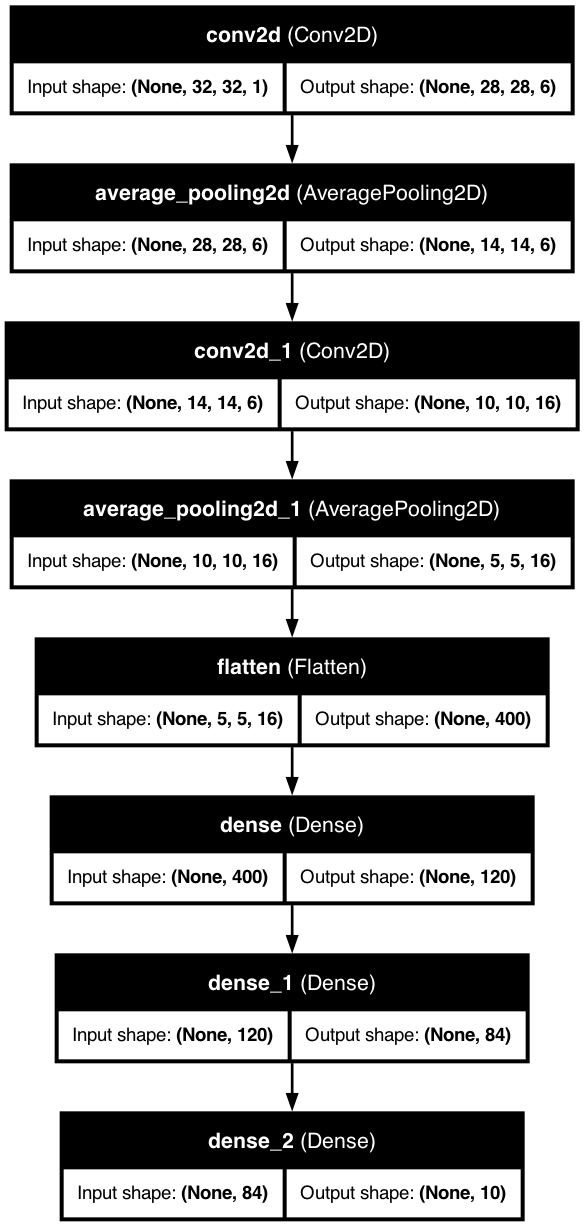

In [12]:
plot_model(
    modelo,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96
)

In [13]:
#
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=5,
)

# Parámetros para entrenamiento
modelo.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

## <span style = 'color: cyan'>***1.6.***</span> Entrenamiento de la red

Para entrenar el modelo, primero se van a dividir los datos en conjuntos de entrenamiento y validación.

In [14]:
#
# División de datos
X_tr, X_ts, y_tr, y_ts = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=103,
)

In [15]:
# Entrenamiento
historia = modelo.fit(
    X_tr,
    y_tr,
    epochs=50,
    validation_split=0.1,
    callbacks=[callback],
)

Epoch 1/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8194 - loss: 0.6130 - val_accuracy: 0.9604 - val_loss: 0.1285
Epoch 2/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9666 - loss: 0.1077 - val_accuracy: 0.9726 - val_loss: 0.0868
Epoch 3/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9773 - loss: 0.0763 - val_accuracy: 0.9798 - val_loss: 0.0746
Epoch 4/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9843 - loss: 0.0507 - val_accuracy: 0.9821 - val_loss: 0.0560
Epoch 5/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9874 - loss: 0.0402 - val_accuracy: 0.9780 - val_loss: 0.0671
Epoch 6/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9896 - loss: 0.0328 - val_accuracy: 0.9815 - val_loss: 0.0675
Epoch 7/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9896 - loss: 0.0318 - val_accuracy: 0.9872 - val_loss: 0.0545
Epoch 8/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9926 - loss: 0.0231 - val_accuracy: 0.

## <span style = 'color: cyan'>***1.6.***</span> Evaluación del modelo

Ahora, se procedará con la revisión del modelo.

### <span style = 'color: green'>***1.6.1.***</span> Proceso de entrenamiento

Se comenzará validando el desempeño de este durante el entrenamiento.

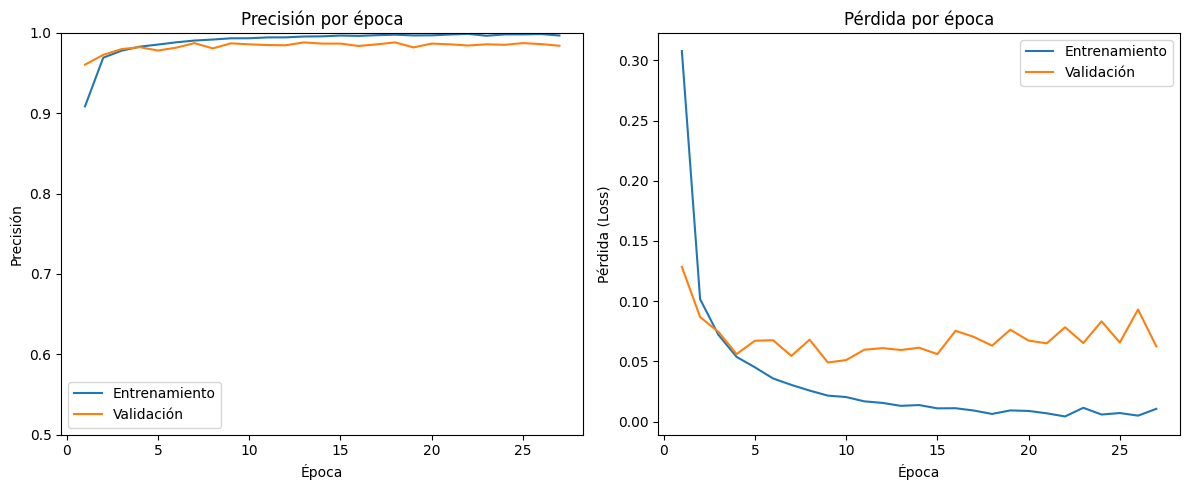

In [16]:
#Visualización de resultados de entrenamiento y validación
epochs = range(1, len(historia.history["accuracy"]) + 1)
plt.figure(figsize=(12, 5))

#Grafica accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, historia.history["accuracy"], label='Entrenamiento')
plt.plot(epochs, historia.history["val_accuracy"], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.ylim([0.5, 1])
plt.title('Precisión por época')
plt.legend()

#Graficar loss
plt.subplot(1, 2, 2)
plt.plot(epochs, historia.history["loss"], label='Entrenamiento')
plt.plot(epochs, historia.history["val_loss"], label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (Loss)')
plt.title('Pérdida por época')
plt.legend()

plt.tight_layout()
plt.show()

<span style = 'color: cyan'>***Comentarios***</span>

La gráfica de la izquierda, asociada con la *precisión* del modelo, da cuenta de que este logra aprender muy bien acerca de las diferentes grafías asociadas a cada uno de los dígitos, y esto ocurre tanto en validación como en entrenamiento, pues para ambos conjuntos de datos se tienen métricas sobre 95 \% (y muy cercanas al 100 \% en el caso de entrenamiento) a partir de la quinta época aproximadamente; adicionalmente, se tiene una brecha baja en las precisiones de ambos conjuntos, lo que da cuenta de un buen ejercicio de ajuste y de pronóstico con el modelo LeNET-5 para este conjunto de datos.

En cuanto a la gráfica de la derecha, relacionada con la *pérdida*, se tiene que esta decrece rápidamente para el conjunto de entrenamiento, estabilizándose alrededor del cero hacia la vigésima época; en contraposición, el conjunto de validación tiene una pérdida que oscila de forma considerable entre una época y otra, y presenta una brecha que, si bien no es muy grave, tampoco es despreciable, por lo que se puede hablar de indicios de un problema de sobreentrenamiento en el modelo. Esto se discutirá más adelante con el resto de métricas.

### <span style = 'color: green'>***1.6.2.***</span> Métricas en entrenamiento y validación

A continuación, se realizará el chequeo para los datos de prueba del modelo.

In [17]:
def plot_confusion_and_metrics_cnn(model, X_train, y_train, X_test, y_test, modelo=None, class_labels=None):
    # Predicción: obtener clase con mayor probabilidad
    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    if y_train.ndim > 1:
        y_train = np.argmax(y_train, axis=1)
    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    # Matrices de confusión
    cm_train = confusion_matrix(y_train, y_pred_train, labels=range(len(class_labels)))
    cm_test = confusion_matrix(y_test, y_pred_test, labels=range(len(class_labels)))

    # Figura con subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Matriz de confusión: entrenamiento
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusión: entrenamiento', fontsize=10)
    axes[0].set_xlabel('Dígito predicho')
    axes[0].set_ylabel('Dígito real')
    axes[0].set_xticks(np.arange(len(class_labels)) + 0.5)
    axes[0].set_xticklabels(class_labels, rotation=90)
    axes[0].set_yticks(np.arange(len(class_labels)) + 0.5)
    axes[0].set_yticklabels(class_labels, rotation=0)

    # Matriz de confusión: validación
    sns.heatmap(cm_test, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), ax=axes[1])
    axes[1].set_title('Confusión: validación', fontsize=10)
    axes[1].set_xlabel('Dígito predicho')
    axes[1].set_ylabel('Dígito real')
    axes[1].set_xticks(np.arange(len(class_labels)) + 0.5)
    axes[1].set_xticklabels(class_labels, rotation=90)
    axes[1].set_yticks(np.arange(len(class_labels)) + 0.5)
    axes[1].set_yticklabels(class_labels, rotation=0)

    fig.suptitle(f"Desempeño del modelo CNN: {modelo}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Métricas de evaluación
    print("MÉTRICAS DE ENTRENAMIENTO")
    print(f"Exactitud: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Kappa: {cohen_kappa_score(y_train, y_pred_train):.4f}")
    print(f"F1 Score (macro): {f1_score(y_train, y_pred_train, average='macro'):.4f}")
    print(f"Precisión (macro): {precision_score(y_train, y_pred_train, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_train, y_pred_train, average='macro'):.4f}")
    print("\nReporte de clasificación:\n")
    print(classification_report(y_train, y_pred_train, target_names=class_labels, digits=4, ))

    print("MÉTRICAS DE VALIDACIÓN")
    print(f"Exactitud: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Kappa: {cohen_kappa_score(y_test, y_pred_test):.4f}")
    print(f"F1 Score (macro): {f1_score(y_test, y_pred_test, average='macro'):.4f}")
    print(f"Precisión (macro): {precision_score(y_test, y_pred_test, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_test, y_pred_test, average='macro'):.4f}")
    print("\nReporte de clasificación:\n")
    print(classification_report(y_test, y_pred_test, target_names=class_labels, digits=4, ))

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


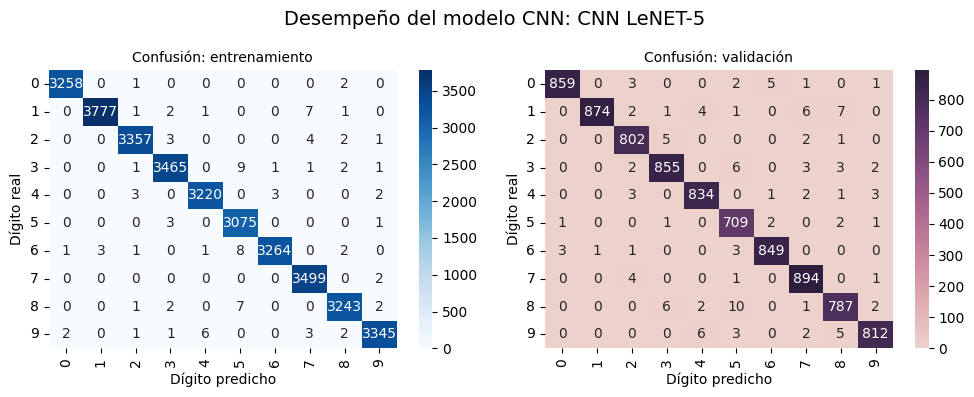

MÉTRICAS DE ENTRENAMIENTO
Exactitud: 0.9971
Kappa: 0.9968
F1 Score (macro): 0.9971
Precisión (macro): 0.9971
Recall (macro): 0.9971

Reporte de clasificación:

              precision    recall  f1-score   support

           0     0.9991    0.9991    0.9991      3261
           1     0.9992    0.9968    0.9980      3789
           2     0.9973    0.9970    0.9972      3367
           3     0.9968    0.9957    0.9963      3480
           4     0.9975    0.9975    0.9975      3228
           5     0.9923    0.9987    0.9955      3079
           6     0.9988    0.9951    0.9969      3280
           7     0.9957    0.9994    0.9976      3501
           8     0.9966    0.9963    0.9965      3255
           9     0.9973    0.9955    0.9964      3360

    accuracy                         0.9971     33600
   macro avg     0.9971    0.9971    0.9971     33600
weighted avg     0.9971    0.9971    0.9971     33600

MÉTRICAS DE VALIDACIÓN
Exactitud: 0.9851
Kappa: 0.9835
F1 Score (macro): 0.9849
P

In [18]:
plot_confusion_and_metrics_cnn(
    modelo,
    X_tr,
    y_tr,
    X_ts,
    y_ts,
    modelo='CNN LeNET-5',
    class_labels=[str(i) for i in range(10)]
)

<span style = 'color: cyan'>***Comentarios***</span>

Las métricas en el conjunto de **entrenamiento** son muy positivas, en la medida que para las diez clases las diferentes métricas (tanto generales o macro, como particulares para cada clase según el reporte de clasificación) se tienen valores muy cercanos al 100 \%. Pensando que este es un problema de clasificación multiclase, vale la pena detallar el coeficiente kappa de Cohen, el cual toma un valor de 99.63 \%. Respecto a la matriz de confusión, se evidencia que básicamente todas las clases tienen todas sus predicciones reales en la diagonal principal (es decir, predicción correcta), habiendo unas pocas instancias dispersas en las demás clases. Si se detalla en cada clase, se obtiene que el dígito uno (‘`1`’) es el que cuenta con la mejor precisión, y el peor ocurre con el seis (‘`6`’). En cuanto a la exhaustividad, se puede resaltar que la peor clase es la cinco (‘`5`’), que suele confundirse con el dígito seis (‘`6`’) o con el dígito ocho (‘`8’). Es importante anotar que, a pesar de que se hable de ‘peor’ métrica, en ningún caso esta es mala, pues siempre son valores muy cercanos a predicciones perfectas (100 \%).

En el conjunto de **validación** también se tienen métricas muy buenas que, en promedio, son dos a tres décimas peores que las del conjunto de validación. Para la generalidad, se tiene un coeficiente kappa de Cohen del 98.35 \%, que es bastante positiva. Desde la particularidad, el dígito uno (‘`1`’) es nuevamente el que mejor precisión tiene, siendo el peor el ocho (‘`8`’). Respecto a la exhaustividad, nuevamente es el dígito (‘5’) el que tiene peor métrica, confudiéndose típicamente con los mismos dígitos que en el conjunto de entrenamiento.

Es importante resaltar que la exactitud (o *accuracy*), el coeficiente kappa de Cohen y el *score* $\text{f}1$ son muy parecidos entre sí en ambos conjuntos: entrenamiento y validación. En este orden de ideas, se puede constatar que **no debe haber preocupación** por el posible **sobreajuste** que se diagnosticó con las curvas de pérdida por época.

### <span style = 'color: green'>***1.6.3.***</span> Visualización de errores en validación

Se graficarán deciséis instancias aleatorias del conjunto de validación que han sido clasificadas erróneamente:

In [19]:
#
# Predicciones en validación:
y_pred_ts = np.argmax(modelo.predict(X_ts), axis=1)

# Instancias erróneas
indices_erroneos = np.where(y_ts != y_pred_ts)[0]
n_erroneos = len(indices_erroneos)

# Selección aleatoria de instancias erróneas
np.random.seed(2025)
indices_aleatorios = np.random.choice(indices_erroneos, size=16, replace=False, )

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


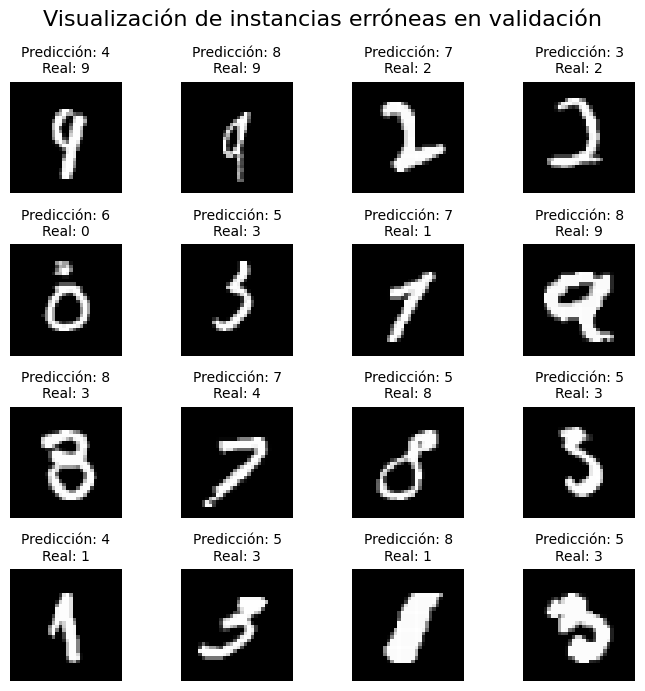

In [20]:
#
# Visualización de instancias erróneas
fig2, axes2 = plt.subplots(4, 4, figsize=(7, 7), )
axes2 = axes2.flatten()
for digito, eje in enumerate(axes2):
    imagen = X_ts[indices_aleatorios[digito]].reshape(32, 32)
    eje.imshow(imagen, cmap='gray')
    eje.set_title(f'Predicción: {y_pred_ts[indices_aleatorios[digito]]}\nReal: {y_ts.iloc[indices_aleatorios[digito]]}', fontsize=10,)
    eje.axis('off')
plt.suptitle('Visualización de instancias erróneas en validación', fontsize=16, )
plt.tight_layout()
plt.show()

<span style = 'color: cyan'>***Comentarios***</span>

Se puede constatar que varias de las instancias clasificadas erróneamente tienen grafías *exóticas*, que se pueden asemejar a otros números y que, por tanto, llevan al modelo a dar tal predicción errónea.